In [1]:
#Zmienić enkoder by analizował w dwóch kierunkach
#Dodać iteracyjne przewidywanie w dekoderze
#Używam średniej po ostatnich stanach w enkoderze zamiast ostatniego stanu
#Spróbować przeskalować wejscie
#Spróbować GRU

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesResampler

/pio/scratch/1/i309016/miniconda/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
with open("../Dane/Datasets/d50.pickle", "rb") as file:
    dataset=pickle.load(file)

resampler=TimeSeriesResampler(256)

dataset=torch.Tensor([resampler.transform(ar.reshape((1,-1,1))).reshape(-1,1) for ar in dataset])

In [4]:
class DilatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dilation, last_state_only=False):
        super().__init__()
        self.hidden_size=hidden_size
        self.dilation=dilation
        self.last_state_only=last_state_only
        
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True)
    
    def forward(self, X, H=None):
        assert X.shape[1]%self.dilation==0, "Wrong second dimension length"
        batchSize=X.shape[0]
        seqLength=X.shape[1]

        if self.last_state_only:
            L=[X[:,self.dilation-1::self.dilation,:]]
        else:
            L=[X[:,i::self.dilation,:] for i in range(self.dilation)]
        X=torch.vstack(L)
        if H is None:
            out,(hid,_)=self.lstm(X)
        else:
            #assert H.shape[0]==0
            #H.reshape(H.shape[1:])
            H=torch.hstack([H for i in range(self.dilation)])
            
            C=torch.zeros_like(H)
            out,(hid,_)=self.lstm(X,(H,C))
        
        X=torch.zeros((batchSize, seqLength, self.hidden_size), device="cuda")
        if self.last_state_only:
            X[:,self.dilation-1::self.dilation,:]=out
        else:
            for i in range(self.dilation):
                X[:,i::self.dilation,:]=out[i*batchSize:(i+1)*batchSize,:,:]
        
        return X, hid.reshape(hid.shape[1:])

In [5]:
class Enkoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1=DilatedRNN(input_size=1, hidden_size=32, dilation=1, last_state_only=True)
        self.L2=DilatedRNN(input_size=32, hidden_size=16, dilation=4, last_state_only=True)
        self.L3=DilatedRNN(input_size=16, hidden_size=16, dilation=16, last_state_only=True)
        self.L4=DilatedRNN(input_size=16, hidden_size=16, dilation=64, last_state_only=True)

    def forward(self, X):
        batchSize=X.shape[0]
        X,h1=self.L1(X)
        #h1=h1.reshape((X.shape[0],-1,h1.shape[-1]))
        X,h2=self.L2(X)
        #h2=h2.reshape((X.shape[0],-1,h2.shape[-1])).mean(dim=1)
        #h2=h2[-batchSize:,:]
        _,h3=self.L3(X)
        #h3=h3.reshape((X.shape[0],-1,h3.shape[-1])).mean(dim=1)
        #h3=h3[-batchSize:,:]
        _,h4=self.L4(X)
        #h4=h4.reshape((X.shape[0],-1,h4.shape[-1])).mean(dim=1)
        #h4=h4[-batchSize:,:]
        #print(h1.shape)
        #print(h2.shape)
        #print(h3.shape)
        return torch.hstack((h1,h2,h3,h4))

In [6]:
class Dekoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.L4=DilatedRNN(input_size=32, hidden_size=16, dilation=1)
        self.L3=DilatedRNN(input_size=40, hidden_size=32, dilation=4)
        self.L2=DilatedRNN(input_size=hidden_size, hidden_size=40, dilation=16)
        self.L1=DilatedRNN(input_size=1, hidden_size=hidden_size, dilation=64)
        
        self.sequential=nn.Sequential(
            nn.Linear(in_features=16, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )

    
    def forward(self, hid, generatedLength=256):
        batchSize=hid.shape[0]
        hid=hid.reshape((1,*hid.shape))
        zera=torch.zeros((batchSize, generatedLength,1),device="cuda")
        
        out,_=self.L1(zera,hid)
        out,_=self.L2(out)
        out,_=self.L3(out)
        out,_=self.L4(out)
        out=self.sequential(out)
        
        #out=torch.empty((batchSize,generatedLength,1),device="cuda")
        #poprzednie=torch.zeros((batchSize,1,1), device="cuda")
        #for i in range(generatedLength):
        #    poprzednie,(hid,C)=self.lstm(poprzednie,(hid,C))
        #    poprzednie=self.linear2(self.linear1(poprzednie))
        #    out[:,i,:]=poprzednie.reshape((batchSize,1))
        return out

In [7]:
class DekoderProsty(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm=nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1,batch_first=True)
        self.sequential=nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    
    def forward(self, hid, generatedLength=256):
        batchSize=hid.shape[0]
        hid=hid.reshape((1,*hid.shape))
        C=torch.zeros_like(hid)
        
        zera=torch.zeros((batchSize, generatedLength,1),device="cuda")
        out,_=self.lstm(zera,(hid,C))
        out=self.sequential(out)
        
        #out=torch.empty((batchSize,generatedLength,1),device="cuda")
        #poprzednie=torch.zeros((batchSize,1,1), device="cuda")
        #for i in range(generatedLength):
        #    poprzednie,(hid,C)=self.lstm(poprzednie,(hid,C))
        #    poprzednie=self.linear2(self.linear1(poprzednie))
        #    out[:,i,:]=poprzednie.reshape((batchSize,1))
        return out

In [8]:
class Klasyfikator(nn.Module):
    def __init__(self,input_size, d_size=512):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(in_features=input_size, out_features=d_size),
            nn.ReLU(),
            nn.Linear(in_features=d_size, out_features=2)
        )
        
    def forward(self, X):
        #print(X.shape)
        return self.sequential(X)

In [9]:
class DTCR(nn.Module):
    """Choć póki co to dosyć szumna nazwa jak na aktualny stan implementacji."""
    def __init__(self):
        super().__init__()
        self.enkoder=Enkoder()
        self.dekoder=Dekoder(80)
        self.klasyfikator=Klasyfikator(80)
    
    def forward(self, X):
        hid=self.enkoder(X)
        out=self.dekoder(hid, generatedLength=X.shape[1])
        labels=self.klasyfikator(hid)
        return out, labels

In [10]:
def generujFalszyweDane(dataset, alpha=0.2):
    """
    Wejscie [batch,seqLength, dimension]
    Zwraca tensor z wygenerowanymi fałszywymi próbkami, gdzie wyjście ma
    kształt [batch, seqLength*2, dimension] i wartości
    [:,:seqLength,:] odpowiadają danym prawdziwym, a [:,seqLength:,:] fałszywym.
    """
    seqLength=dataset.shape[1]
    out=torch.empty((dataset.shape[0], seqLength*2, *dataset.shape[2:]))
    #print(out.shape)
    out[:,:seqLength,:]=dataset
    out[:,seqLength:,:]=dataset
    for i in range(dataset.shape[0]):
        ind=np.random.choice(seqLength,int(seqLength*alpha),replace=False)
        ind2=ind.copy()+seqLength
        np.random.shuffle(ind2)
        #print(ind2,ind)
        out[i,ind2,:]=dataset[i,ind,:]
    return out

In [11]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50):
    kosztKlasyfikacji=nn.CrossEntropyLoss()
    def evalBatch(batch):
        klasyPrawdziwe=torch.ones(batch.shape[0],dtype=torch.long)
        klasyFalszywe=torch.zeros_like(klasyPrawdziwe)
        if ifCuda:
            batch=batch.to("cuda")
            klasyPrawdziwe=klasyPrawdziwe.to("cuda")
            klasyFalszywe=klasyFalszywe.to("cuda")
        klasy=torch.hstack((klasyPrawdziwe, klasyFalszywe))
        seqLength=256
        resultPrawdziwe, labelsPrawdziwe=model(batch[:,:seqLength,:])
        resultFalszywe, labelsFalszywe=model(batch[:,seqLength:,:])
        diffrenceWithNext=(resultPrawdziwe-batch[:,:seqLength,:])**2
        scoreOdtwarzania=torch.sum(diffrenceWithNext)
        scoreKlasyfikacji=kosztKlasyfikacji(torch.vstack((labelsPrawdziwe,labelsFalszywe)),klasy)
        score=scoreOdtwarzania+scoreKlasyfikacji
        return score, (scoreOdtwarzania, scoreKlasyfikacji)
    
    if ifCuda:
        model=model.to("cuda")
    
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    
    dataset=generujFalszyweDane(dataset)
    validationset=generujFalszyweDane(validationset)
    
    data_validation=torch.utils.data.DataLoader(validationset,batch_size=batch_size)
    data_train=torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)

    try:    
        for epoch in range(epoch_count):
            #Training
            for batch in data_train:
                iter_counter+=1
                optimizer.zero_grad()
                score,_=evalBatch(batch)
                score.backward()
                optimizer.step()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | loss {1: >9.7f}".format(
                        iter_counter,score.item()/batch_size))
            #Validation
            validationScore=0
            reconstructionScore=0
            clasificationScore=0
            with torch.no_grad():
                for batch in data_validation:
                    wyn=evalBatch(batch)
                    validationScore+=wyn[0]
                    reconstructionScore+=wyn[1][0]
                    clasificationScore+=wyn[1][1]
            avgValidationScore=validationScore/validationset.shape[0]
            avgRecScore=reconstructionScore/validationset.shape[0]
            avgClasScore=clasificationScore/validationset.shape[0]

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "Epoch {0: >2} | valid: {1: >7.6f} | best valid: {2: >7.6f} | best epoch {3: >2} | rec: {4: >7.6f} | clas: {5: >7.6f}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch, avgRecScore,avgClasScore
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
    except KeyboardInterrupt:
        pass
    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param       

In [12]:
model=DTCR()

In [13]:
dataset.shape

torch.Size([171988, 256, 1])

In [89]:
podzial=165000
trainset=dataset[:podzial,:,:]
testset=dataset[podzial:,:,:]
testset=(testset-trainset.min())/(trainset.max()-trainset.min())
trainset=(trainset-trainset.min())/(trainset.max()-trainset.min())
W=uczModel(model, trainset,testset, batch_size=256, 
           log_every=20, lr=0.001, epoch_count=20)

--------------------------------------------------------------------------------------------------
Epoch 19 | valid: 0.057351 | best valid: 0.057351 | best epoch 19 | rec: 0.054753 | clas: 0.002597
--------------------------------------------------------------------------------------------------

Loading best params on validation set (epoch 19)



In [90]:
torch.save(model.state_dict(), f"../Modele/DTCR-OdtwarzanieIKlasyfikacja-DilatedDekoder-d50(50epok)-poprawnyZbiorTestowy-{str(time.time())}.pth")
#with open(f"../Modele/DTCR-OdtwarzanieIKlasyfikacja-DilatedDekoder-d10+d50(2x30epok)-{str(time.time())}.pickle","wb") as plik:
#    pickle.dump(model, plik)

In [91]:
szereg=testset[:4,:,:]
szereg=szereg.to("cuda")

In [92]:
X,_=model(szereg)

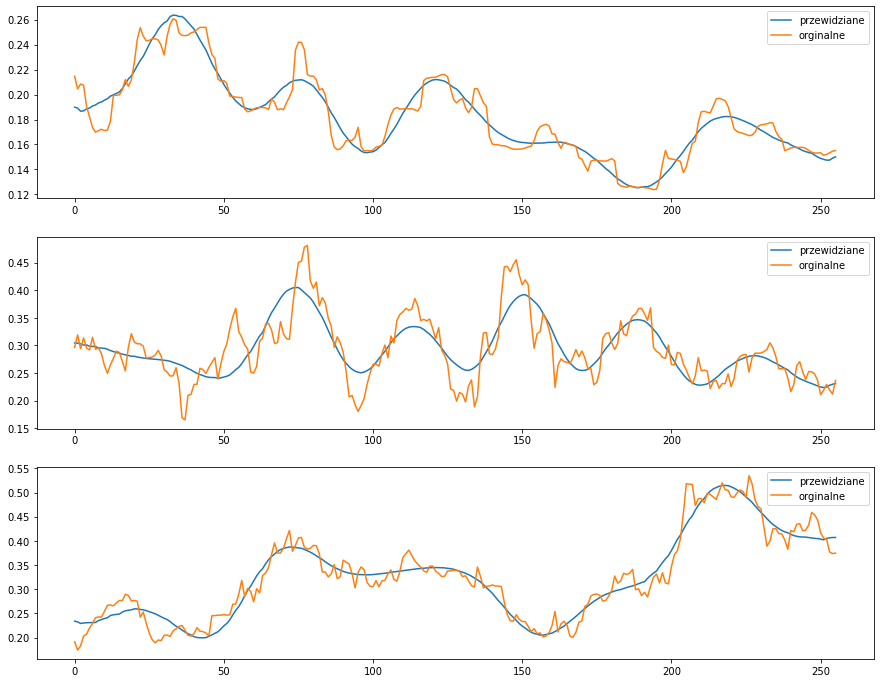

In [93]:
plt.gcf().set_size_inches((15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.array(X[i,:,:].cpu().detach()), label="przewidziane")
    plt.plot(np.array(szereg[i,:,:].cpu()), label="orginalne")
    plt.legend()

In [94]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [95]:
def zakodujDane(dataset, model, batch_size=256):
    model=model.to("cuda")
    data=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
    L=[model.enkoder(batch.to("cuda")).cpu().detach() for batch in data]
    return torch.vstack(L)

In [96]:
encoded_data=zakodujDane(dataset, model)

In [97]:
encoded_data.shape

torch.Size([171988, 80])

In [115]:
pca=PCA(n_components=60, whiten=False)
pca.fit(np.array(encoded_data))

PCA(n_components=60)

In [116]:
pca.n_components_

60

In [117]:
szereg=trainset[:4,:,:].to("cuda")
hid=model.enkoder(szereg)
hid_pca=pca.inverse_transform(pca.transform(np.array(hid.cpu().detach())))
X_pca=model.dekoder(torch.Tensor(hid_pca).to("cuda"), 256)
X,_=model(szereg)

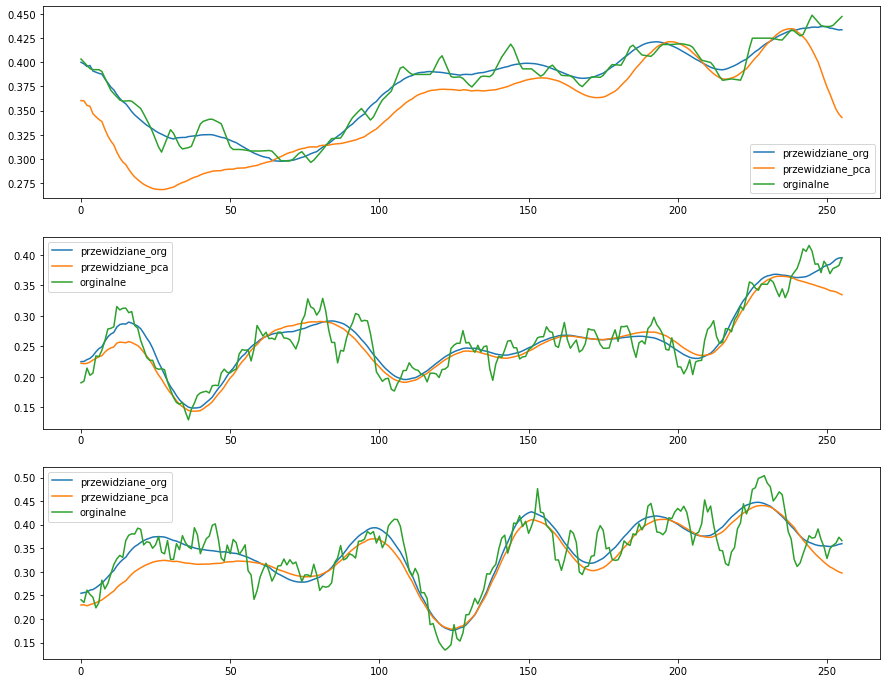

In [118]:
plt.gcf().set_size_inches((15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.array(X[i,:,:].cpu().detach()), label="przewidziane_org")
    plt.plot(np.array(X_pca[i,:,:].cpu().detach()), label="przewidziane_pca")
    plt.plot(np.array(szereg[i,:,:].cpu()), label="orginalne")
    plt.legend()

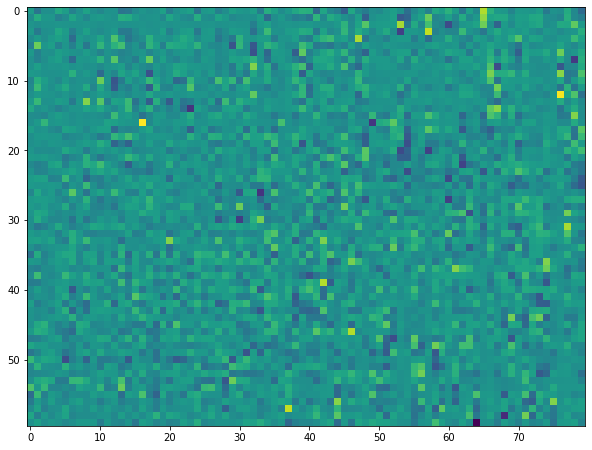

In [119]:
plt.gcf().set_size_inches((10,10))
plt.imshow(pca.components_[:,:])

Z poziomu:
- L1 mamy 3 znaczące udziały
- L2 mamy 5 znaczących udziałów
- L3 mamy 4 znaczące udziały (choć trochę trudniej jest rozróżnić znaczące/nieznaczące)
- L4 mamy 8 znaczących udziałów

In [73]:
np.sort(np.argmax(pca.components_[:16,:], axis=1))

array([14, 35, 37, 40, 53, 53, 63, 66, 67, 67, 68, 71, 74, 77, 78, 79])

Z pośród 16 maksimów:
- 1 pochodzi z L1
- 3 pochodzą z L2
- 3 pochodzą z L3
- 9 pochodzi z L4

In [120]:
tsne=TSNE(perplexity=70, learning_rate=600)

encoded_data_tsne=tsne.fit_transform(encoded_data[:10000,:])

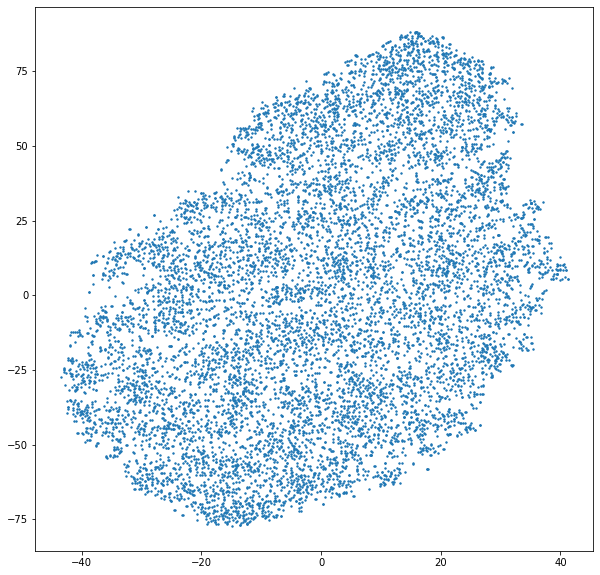

In [121]:
plt.gcf().set_size_inches((10,10))
plt.scatter(encoded_data_tsne[:,0],encoded_data_tsne[:,1],s=2)

In [122]:
pca=PCA(n_components=2)
pca.fit(np.array(encoded_data))
encoded_data_pca=pca.transform(encoded_data)

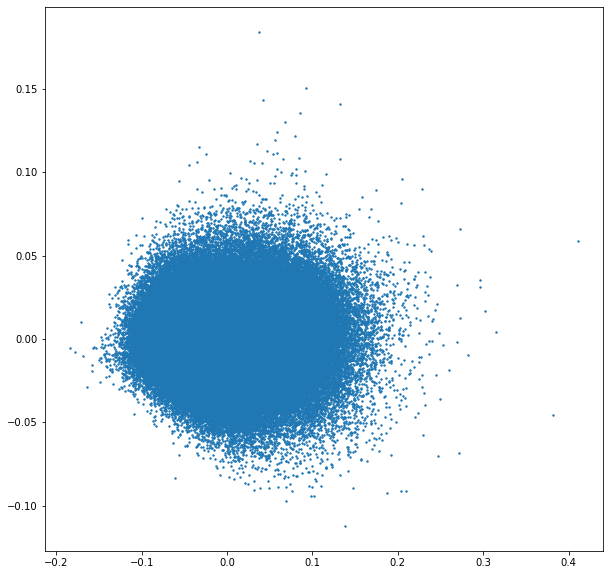

In [123]:
plt.gcf().set_size_inches((10,10))
plt.scatter(encoded_data_pca[:,0],encoded_data_pca[:,1],s=2)